# HW 2 Long Shot-Term Memory

Дополнительные библиотеки по аугментации данных:
- [albumentations](https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb)
- [scikit-image](https://scikit-image.org/)

### All Datasets

#### Path №1
#### https://github.com/shahroudy/NTURGB-D

#### Path №2 
#### * http://rose1.ntu.edu.sg/datasets/actionrecognition.asp
#### * https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [5]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from torch import optim
import time
import math
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

device = torch.device('cpu')

cpu


##### [Original state](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)  

In [6]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

#### Classes:
* sitting down
* clapping
* jump up
* cheer up
* hand waving

In [7]:
class Skeleton_Dataset_Creator():
    def __init__(self, data_path, broken_files_path, max_frame=300):
        self.data_path = "nturgb+d_skeletons/"
        self.broken_files_path = "NTU_RGBD_samples_with_missing_skeletons.txt"
        self.training_subjects = list(range(0, 28)) #количество людей выполняющих действия
        self.training_classes = [8, 10, 22, 23, 27] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
        self.training_cameras = [1, 2, 3] 

        self.max_body_true = 1
        self.max_body_kinect = 1

        self.num_joint = 25
        self.max_frame = max_frame # Длина отрезка которую мы вычленяем из большого датасета
        
        
        self.working_files_with_labels, self.action_classes = self.read_data(data_path, broken_files_path)
        
        LABELS = {v: k for k, v in self.action_classes.items()}
        
    def read_data(self, data_path, broken_files_path):
        data_path = self.data_path
        broken_files_path = self.broken_files_path
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in self.training_classes and camera_id in self.training_cameras:  #and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename,action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
    #                     labels.append([action_class])
        print("action classes: ", action_classes)
        print("action files: ", files_counter)

        return files, action_classes
    
    def get_nonzero_std(s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s

# Функция фильтр для того, что бы найти только координаты x,y,z(т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence

    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data
    
    def create_coords_blocks(self, test_file, chonk_len = 45):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def creat_data(self, name):
        data = []
        labels = []
        ##########################################################################
        #numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0, 5 :0} #####
        ##################################################################
        
        numbers = {}
        i = 0
        for elem in self.training_classes:
            numbers[i] = 0
            i += 1
        
        for file in self.working_files_with_labels:
            frames_blocks, label = self.create_coords_blocks(file)
            #print(label, label[0], numbers)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        test_data.to_csv(name, index = False)
        return test_data

In [9]:
class Skeleton_Dataset(Dataset):
    def __init__(self, mode="F", data_path=None, broken_files_path=None, file_path=None,  transform=None, max_frame=300):
        if mode=="C":
            cr = Skeleton_Dataset_Creator(data_path=data_path, broken_files_path=broken_files_path, max_frame=max_frame)
            self.data = cr.creat_data("test_cr.csv")
            self.transform = transform
            self.labels = self.data.iloc[:,-1]
        if mode=="F":
            self.data = pd.read_csv(file_path)
            self.transform = transform
            self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        

        return (item, label) 

## Next

In [122]:
dataset = Skeleton_Dataset(mode="C",max_frame=150, data_path = "nturgb+d_skeletons/", broken_files_path = "NTU_RGBD_samples_with_missing_skeletons.txt")

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [49]:
dataset = Skeleton_Dataset(file_path = "skels.csv", transform=None)

In [58]:
dataset = Skeleton_Dataset(file_path = "test_cr.csv", transform=None)

In [61]:
import pandas as pd
skeletons = pd.read_csv("test_cr.csv")

In [100]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping", 5: "Unknown", 6: "Unknown2", 7: "Unknown3", 8: "Unknown4", 9: "Unknown5"}

In [64]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103227,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496548,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1
2,0.430001,0.024285,4.098490,0.424111,0.227365,4.005508,0.417157,0.427353,3.902021,0.395301,...,0.098534,0.515498,3.738000,0.243639,0.441711,3.635301,0.292146,0.468907,3.595111,2
3,0.399282,-0.026338,4.099298,0.382165,0.177244,4.002089,0.359935,0.376536,3.893836,0.338453,...,0.300487,0.700893,3.694455,0.535627,0.814146,3.868758,0.530421,0.797046,3.864750,3
4,0.449151,0.001842,4.170505,0.412885,0.192257,4.103466,0.375976,0.379683,4.026225,0.401664,...,0.723439,0.436599,4.077281,0.535588,0.585105,4.202623,0.536817,0.559229,4.186821,3


In [63]:
skeletons.shape

(809, 3376)

## Dataloader

In [29]:
from torch.utils.data import DataLoader, Dataset

``` DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None) ```

##### * Класс Dataset и класс Dataloader помогают передавать собственные обучающие данные в сеть. 
##### *Класс Dataset используется для обеспечения интерфейса для доступа ко всем обучающим или тестовым образцам в вашем наборе данных. Для этого необходимо реализовать как два обязательных метода, __getitem__ и __len_. 

In [30]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу
         # - Применяет выбранные трансформации к данным

    def __len__(self):
        # # Возвращает данные и лейблы
       
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
         # - Применяет выбранные трансформации к данным
        return len(self.samples) #возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 
    

In [32]:
skel, lab = dataset.__getitem__(41)
skel, lab = dataset[41]

In [29]:
LABELS[lab]

'sitting down'

In [39]:
int(0.75*len(dataset))

606

In [40]:
int(0.25*len(dataset))

202

In [42]:
len(dataset)

809

In [101]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),len(dataset)-int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [107]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (lstm2): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [68]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(5):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        #print(device)
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        #print(output)
        #print(labels)
        loss = criterion(output, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 1 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

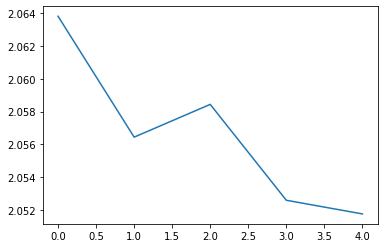

In [85]:
#%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [104]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   9.734513274336283


# Итого 
1) Полноценное тестирование требует слишком много времени.

2) Прямая зависимость кол-ва классов и времени на  обучение, больше классов -  дольше надо учить. 